In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

df = pd.read_csv('../data/UNSW_2018_IoT_Botnet_Full5pc_2.csv')

# حذف ویژگی‌های زمانی (رفع data leakage)
df = df.drop(columns=['stime', 'ltime'])

X = df.select_dtypes(include=['int64', 'float64'])
y = df['category'].map({'DoS': 0, 'DDoS': 1})

print(X.shape)
print(y.value_counts())


C:\Users\szb20\AppData\Local\Temp\ipykernel_22076\504153074.py:8: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/UNSW_2018_IoT_Botnet_Full5pc_2.csv')


(1000000, 35)
category
0    650260
1    349740
Name: count, dtype: int64


In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [3]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest (No Time Features)")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest (No Time Features)
[[130052      0]
 [     0  69948]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    130052
           1       1.00      1.00      1.00     69948

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



In [4]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    verbose=0
)

cb.fit(X_train, y_train)

y_pred_cb = cb.predict(X_test)
y_prob_cb = cb.predict_proba(X_test)[:,1]

print("CatBoost (No Time Features)")
print(confusion_matrix(y_test, y_pred_cb))
print(classification_report(y_test, y_pred_cb))


CatBoost (No Time Features)
[[130052      0]
 [     0  69948]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    130052
           1       1.00      1.00      1.00     69948

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



In [5]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:,1]

print("XGBoost (No Time Features)")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost (No Time Features)
[[130052      0]
 [     1  69947]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    130052
           1       1.00      1.00      1.00     69948

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



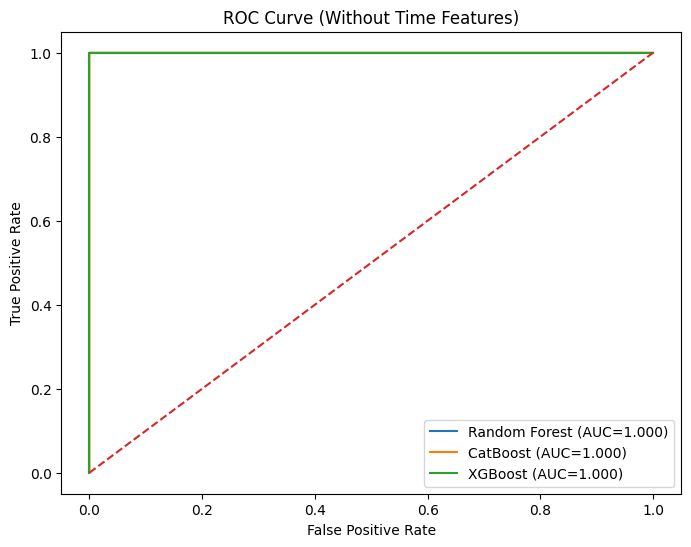

In [6]:
plt.figure(figsize=(8,6))

for name, y_prob in [
    ('Random Forest', y_prob_rf),
    ('CatBoost', y_prob_cb),
    ('XGBoost', y_prob_xgb)
]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})')

plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Without Time Features)')
plt.legend()
plt.show()


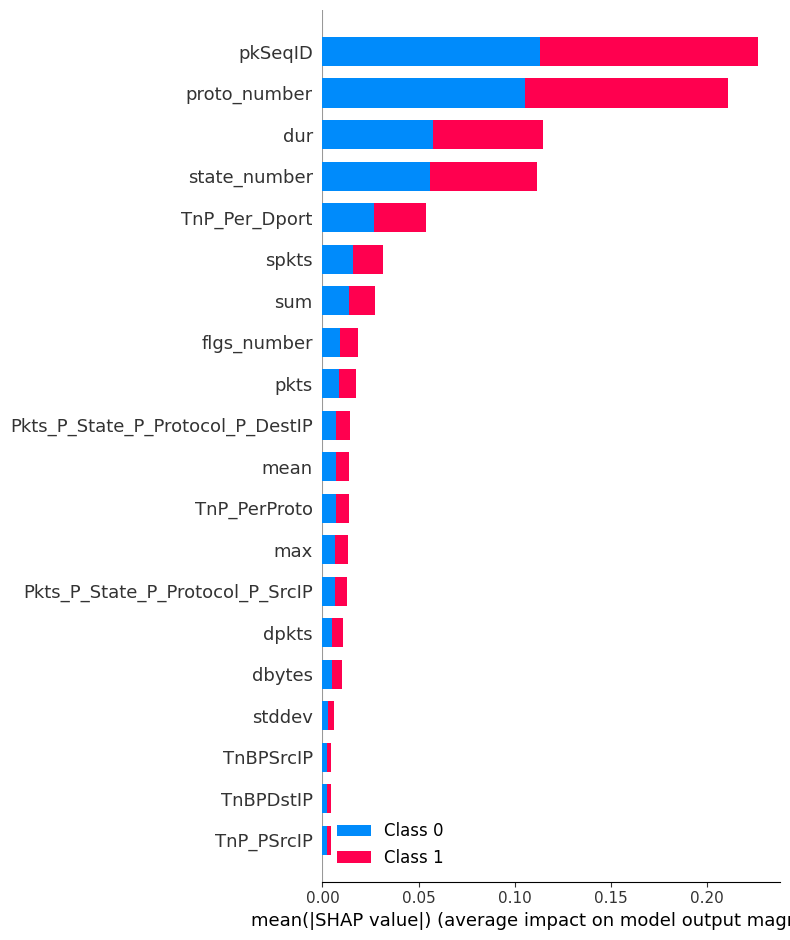

In [7]:
import shap

explainer1 = shap.TreeExplainer(rf)
shap_values1 = explainer1.shap_values(X_test)
shap.summary_plot(shap_values1, X_test, plot_type="bar", show=True)


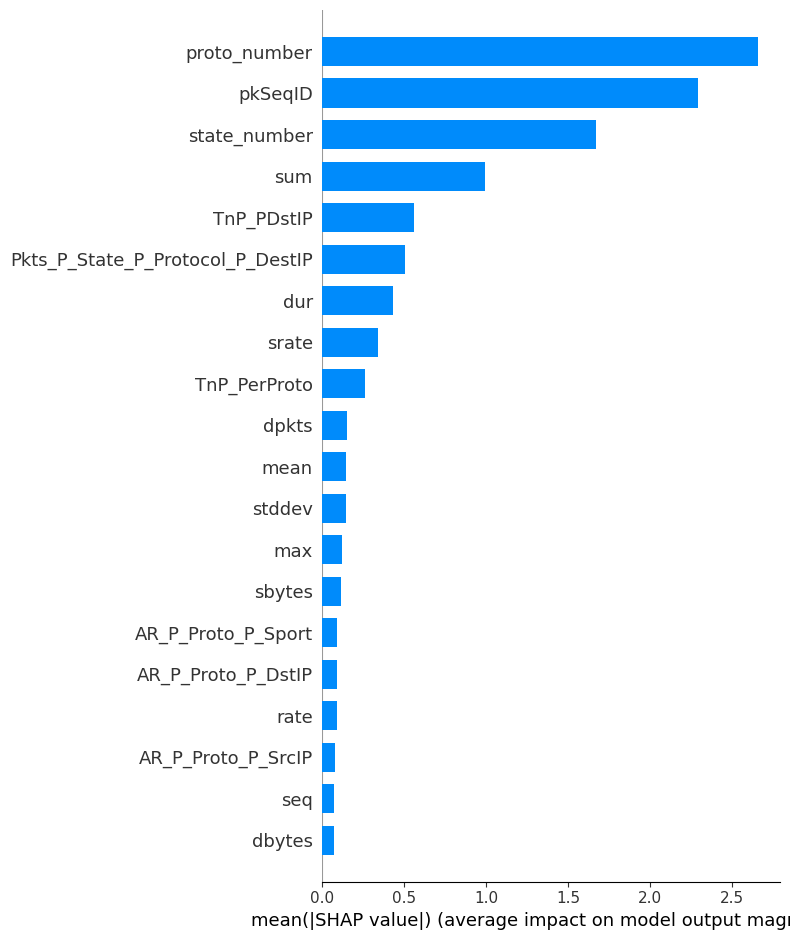

In [8]:
explainer2 = shap.TreeExplainer(cb)
shap_values2 = explainer2.shap_values(X_test)
shap.summary_plot(shap_values2, X_test, plot_type="bar", show=True)


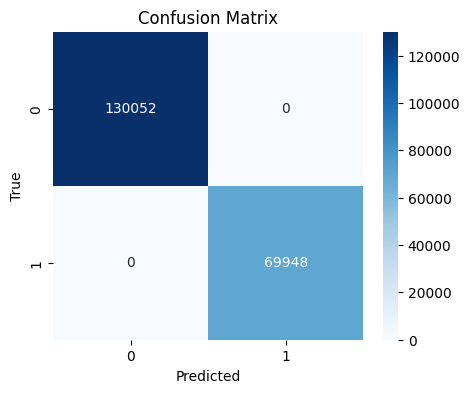

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    130052
           1       1.00      1.00      1.00     69948

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))


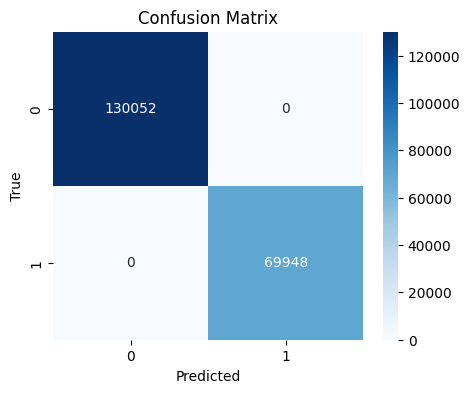

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    130052
           1       1.00      1.00      1.00     69948

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = cb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))


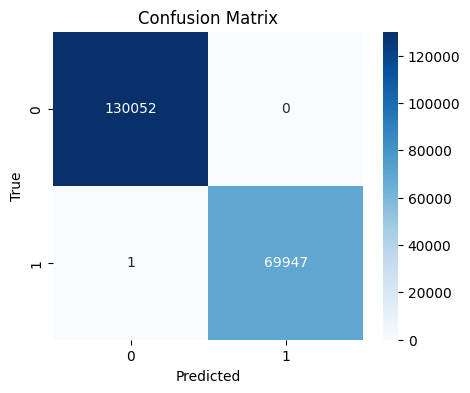

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    130052
           1       1.00      1.00      1.00     69948

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = xgb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))
